In [1]:
import os
import glob
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm.auto import tqdm

/home/zhangzr/anaconda3/envs/mmseg-kaggle/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read csv and extract meta info

In [2]:
df_train = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")
df_train = df_train.sort_values(["id", "class"]).reset_index(drop = True)
df_train["patient"] = df_train.id.apply(lambda x: x.split("_")[0])
df_train["days"] = df_train.id.apply(lambda x: "_".join(x.split("_")[:2]))

all_image_files = sorted(glob.glob("../input/uw-madison-gi-tract-image-segmentation/train/*/*/scans/*.png"), key = lambda x: x.split("/")[3] + "_" + x.split("/")[5])
size_x = [int(os.path.basename(_)[:-4].split("_")[-4]) for _ in all_image_files]
size_y = [int(os.path.basename(_)[:-4].split("_")[-3]) for _ in all_image_files]
spacing_x = [float(os.path.basename(_)[:-4].split("_")[-2]) for _ in all_image_files]
spacing_y = [float(os.path.basename(_)[:-4].split("_")[-1]) for _ in all_image_files]
df_train["image_files"] = np.repeat(all_image_files, 3)
df_train["spacing_x"] = np.repeat(spacing_x, 3)
df_train["spacing_y"] = np.repeat(spacing_y, 3)
df_train["size_x"] = np.repeat(size_x, 3)
df_train["size_y"] = np.repeat(size_y, 3)
df_train["slice"] = np.repeat([int(os.path.basename(_)[:-4].split("_")[-5]) for _ in all_image_files], 3)
df_train

,id,class,segmentation,patient,days,image_files,spacing_x,spacing_y,size_x,size_y,slice
0,case101_day20_slice_0001,large_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,28
1,case101_day20_slice_0001,small_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,28
2,case101_day20_slice_0001,stomach,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,28
3,case101_day20_slice_0002,large_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,129
4,case101_day20_slice_0002,small_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,129
...,...,...,...,...,...,...,...,...,...,...,...
115483,case9_day22_slice_0143,small_bowel,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,73
115484,case9_day22_slice_0143,stomach,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,73
115485,case9_day22_slice_0144,large_bowel,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,108
115486,case9_day22_slice_0144,small_bowel,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,108


# Make mmseg-format data (2.5D by default)

In [3]:
def rle_decode(mask_rle, shape):
    s = np.array(mask_rle.split(), dtype=int)
    starts, lengths = s[0::2] - 1, s[1::2]
    ends = starts + lengths
    h, w = shape
    img = np.zeros((h * w,), dtype = np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)

!mkdir -p ../data/mmseg_train_25d_carno/{images,labels,splits}
for day, group in tqdm(df_train.groupby("days")):
    patient = group.patient.iloc[0]
    imgs = []
    msks = []
    file_names = []
    for file_name in group.image_files.unique():
        img = cv2.imread(file_name, cv2.IMREAD_ANYDEPTH)
        segms = group.loc[group.image_files == file_name]
        masks = {}
        for segm, label in zip(segms.segmentation, segms["class"]):
            if not pd.isna(segm):
                mask = rle_decode(segm, img.shape[:2])
                masks[label] = mask
            else:
                masks[label] = np.zeros(img.shape[:2], dtype = np.uint8)
        masks = np.stack([masks[k] for k in sorted(masks)], -1)
        imgs.append(img)
        msks.append(masks)
        
    imgs = np.stack(imgs, 0)
    msks = np.stack(msks, 0)
    for i in range(msks.shape[0]):
        img = imgs[[max(0, i - 2), i, min(imgs.shape[0] - 1, i + 2)]].transpose(1,2,0) # 2.5d data
        msk = msks[i]
        new_file_name = f"{day}_{i}.png"
        cv2.imwrite(f"../data/mmseg_train_25d_carno/images/{new_file_name}", img)
        cv2.imwrite(f"../data/mmseg_train_25d_carno/labels/{new_file_name}", msk)

100%|██████████| 274/274 [06:24<00:00,  1.40s/it]


# Make fold splits

In [4]:
all_image_files = glob.glob("../data/mmseg_train_25d_carno/images/*")
patients = [os.path.basename(_).split("_")[0] for _ in all_image_files]


from sklearn.model_selection import GroupKFold

split = list(GroupKFold(5).split(patients, groups = patients))

for fold, (train_idx, valid_idx) in enumerate(split):
    with open(f"../data/mmseg_train_25d_carno/splits/fold_{fold}.txt", "w") as f:
        for idx in train_idx:
            f.write(os.path.basename(all_image_files[idx])[:-4] + "\n")
    with open(f"../data/mmseg_train_25d_carno/splits/holdout_{fold}.txt", "w") as f:
        for idx in valid_idx:
            f.write(os.path.basename(all_image_files[idx])[:-4] + "\n")

# Check 2.5d data

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import numpy as np

In [2]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 174 175 176 177 178 179 180 181
 182 184 185 186 187 188 189 190 191 192 193 194 195 196 197 199 200 201
 203 206 207 209 210 212 214 216 218 222 223 224 226 230 231 232 233 237
 241 244 255]
[0 1]


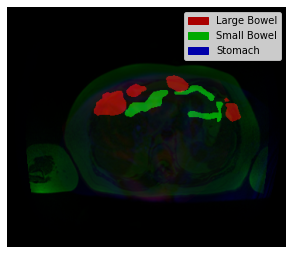

In [4]:
i=10
img_name_list = os.listdir('/home/zhangzr/mmsegmentation_kaggle/data/mmseg_train_25d_new/images')
img = load_img(os.path.join('/home/zhangzr/mmsegmentation_kaggle/data/mmseg_train_25d_new/images',img_name_list[i]))
mask_path = os.path.join('/home/zhangzr/mmsegmentation_kaggle/data/mmseg_train_25d_new/labels', img_name_list[i])
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
print(np.unique(img))
print(np.unique(mask))
plt.figure(figsize=(5,5))
mask[mask==1]=255
show_img(img, mask=mask)